# Sentiment Classification Using BERT Embeddings and Logistic Regression

#### This notebook demonstrates a simple yet effective approach for sentiment classification by combining **BERT-based sentence embeddings** with a **Logistic Regression** classifier. 

#### The pipeline involves extracting dense vector representations of text using the SentenceTransformer library and then training a linear model to distinguish between sentiment categories (positve, negative, neutral). T

#### We demonstrated the preprocessing steps, model training, evaluation using a labeled dataset (the llm_judge_train dataset, which was llm classified, using a method called ** LLM as a judge **), and application of the trained classifier on a separate validation set. 



In [ ]:
# Loading librairies

from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import pandas as pd
from tqdm import tqdm


In [ ]:
# Reading the labeled training dataset from CSV

df_train = pd.read_csv("dataset_llm_judge.csv")


In [3]:
print(df_train.columns)

Index(['target', 'id', 'text'], dtype='object')


In [ ]:
# Converting all values in the target column to lowercase 
# and removing leading/trailing whitespaces
df_train["target"] = df_train["target"].str.lower().str.strip()


In [ ]:
# Reading the validation dataset with custom settings to handle formatting

df_valid = pd.read_csv("desafio_DS/dataset_valid.csv",
    sep="|",
    engine="python",
    header=None,
    names=["id", "text"],
    quoting=3,            # ignoring quotes
    on_bad_lines="warn",  # warning about bad lines
    encoding="utf-8"      # allowing to switch to latin1 if there are encoding issues
)


In [6]:
print(df_valid.head())
print(df_valid.columns)

        id                                               text
0      NaN                                              input
1  19784.0                        The pizza was really good .
2  19788.0  Knowledge of the chef and the waitress are bel...
3  19792.0                               The service was ok .
4  19796.0  I 'm happy to have Nosh in the neighborhood an...
Index(['id', 'text'], dtype='object')


In [ ]:
# Removinfg any accidental header rows (e.g., "input") and reset index
df_valid = df_valid[df_valid["text"] != "input"].reset_index(drop=True)


In [ ]:
# Loading pre-trained BERT-based sentence embedding model
model = SentenceTransformer("all-MiniLM-L6-v2")
X = model.encode(df_train["text"].tolist())  # <-- aqui df_train é seu dataset anotado pela LLM
y = df_train["target"]

In [ ]:
# Spliting the embeddings and labels into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
# Generating BERT embeddings for the validation dataset
X_valid = model.encode(df_valid["text"].tolist()) # 

# Predicting sentiment labels with trained classifier
y_valid_pred = clf.predict(X_valid)

# Saving as Dataframe
df_valid["target_predito"] = y_valid_pred

# Exporting as CSV
df_valid.to_csv("predicoes_valid.csv", index=False)


In [ ]:
# Performing a holdout split on the labeled training data to evaluate model performance
# Useful for internal validation before applying the model to unseen data.
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# X represents input features (BERT embeddings)
# Y are the target sentiment labels
# test_size represents the 20% proportion of the dataset to include in the test split

## New Training

In [ ]:
# Initializing a new instance of Logistic Regression with a max of 1000 iterations
clf_holdout = LogisticRegression(max_iter=1000)

# Training the model on the training portion of the holdout split
# X_train_split represents BERT embeddings for training
# y_train_split corresponding sentiment labels
clf_holdout.fit(X_train_split, y_train_split)

LogisticRegression(max_iter=1000)

## Model Evaluation on holdout test dataset

/Users/ericacarneiro/Code/Github/Atento_Test/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ericacarneiro/Code/Github/Atento_Test/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ericacarneiro/Code/Github/Atento_Test/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

    negative       0.72      0.46      0.57        28
     neutral       0.00      0.00      0.00         4
    positive       0.83      0.95      0.89        99

    accuracy                           0.82       131
   macro avg       0.52      0.47      0.48       131
weighted avg       0.78      0.82      0.79       131



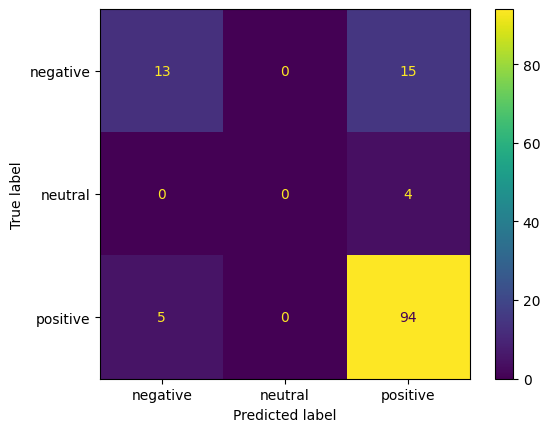

In [ ]:
# Generating sentiment predictions on the holdout test set
y_pred_split = clf_holdout.predict(X_test_split)

# Print a classification report
print(classification_report(y_test_split, y_pred_split))

# Displaying a confusion matrix for the holdout test set
ConfusionMatrixDisplay.from_predictions(y_test_split, y_pred_split)

## Initial Results

#### Although the model achieves an accuracy of 82%, it also reveals significant class imbalance and poor performance on minority classes. The model predicts very well positive, classes, as represented by the high accuracy metrica for the positive class. 

#### In the case of negative classes, the are well classified when found, but still, many actual negative labels are missed, as seen in the loe recall metric for the negative class. 

#### For Neutral classes, the model completely fails to identify any neutral samples. There can be many reasons for that, but we believe the class imbalance (only 4 samples) is the reponsible for those results. 

#### Macro avg F1: 0.48 indicates poor average performance across classes.
#### Weighted avg F1: 0.79 → might be due to the dominance of the “positive” class.

## Train Logistic Regression with Class Weight Balancing

#### Due to the first results, we decided to try to correct class imbalance - especially in the case of underrepresented "neutral" class - by assigning higher weights to less frequent classes during training. This can help improve recall and F1-score for minority classes.

In [ ]:
# Initializing Logistic Regression with balanced class weights

clf_holdout2 = LogisticRegression(max_iter=1000, class_weight="balanced") # 'class_weight="balanced"' automatically adjusts weights inversely proportional to class frequencies

# Retraining the classifier on the holdout training split
clf_holdout2.fit(X_train_split, y_train_split)

LogisticRegression(class_weight='balanced', max_iter=1000)

              precision    recall  f1-score   support

    negative       0.53      0.75      0.62        28
     neutral       0.08      0.25      0.12         4
    positive       0.94      0.74      0.82        99

    accuracy                           0.73       131
   macro avg       0.51      0.58      0.52       131
weighted avg       0.82      0.73      0.76       131



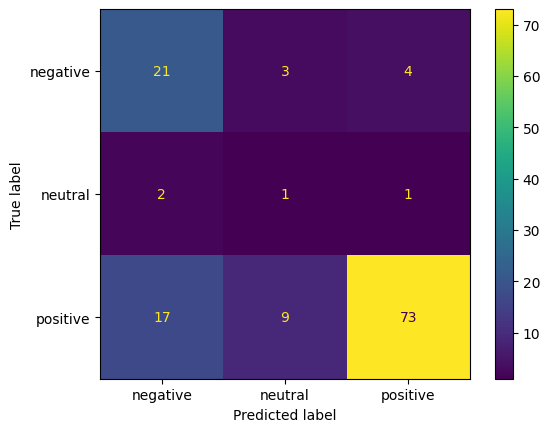

In [ ]:
# Generating sentiment predictions on the holdout2 test set
y_pred_split = clf_holdout2.predict(X_test_split)
# Print a classification report
print(classification_report(y_test_split, y_pred_split))
# Displaying a confusion matrix for the holdout2 test set
ConfusionMatrixDisplay.from_predictions(y_test_split, y_pred_split)

In [ ]:
# Generating a DataFrame with true and predicted labels for the holdout2 test set
df_holdout = pd.DataFrame({
    "true": y_test_split,
    "predicted": y_pred_split
})

# Saving as CSV
df_holdout.to_csv("bert_holdout_result.csv", index=False)

In [ ]:
# Aligning LLM-based validation DataFrames to the same number of rows as the holdout set (131 rows)
df_llm_alinhado = df_valid_llm.iloc[:131].reset_index(drop=True)




In [ ]:

df_valid_llm = pd.read_csv("dataset_llm_judge_valid.csv")  # llm_judge


In [ ]:
#Bert with weitght balanced dataset
df_bert_hold = pd.read_csv("bert_holdout_result.csv")

In [ ]:
import matplotlib.pyplot as plt


BERT Holdout vs LLM
              precision    recall  f1-score   support

    negative       0.25      0.29      0.27        35
     neutral       0.23      0.38      0.29         8
    positive       0.69      0.61      0.65        88

    accuracy                           0.51       131
   macro avg       0.39      0.42      0.40       131
weighted avg       0.55      0.51      0.53       131



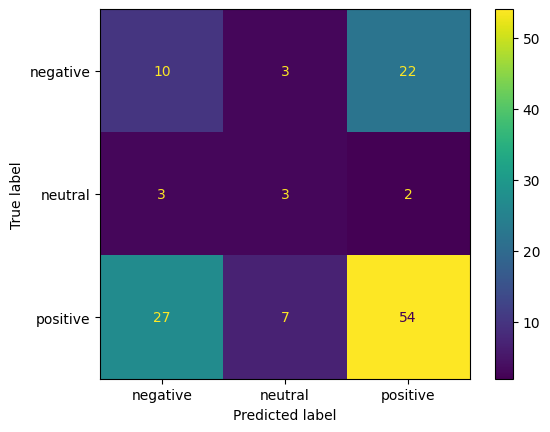

In [ ]:
# Evaluation and comparison of the LLM-based validation set with the BERT holdout set
print("BERT Holdout vs LLM")
print(classification_report(df_llm_alinhado["target"], df_bert_hold["predicted"], zero_division=0))
ConfusionMatrixDisplay.from_predictions(df_llm_alinhado["target"], df_bert_hold["predicted"])


## Results and Analysis

#### The 51% overall **Accuracy** suggests that the model is correct slightly more than half the time when compared to LLM outputs — a major drop from earlier performance against logistic regression without balance, suggesting a mismatch in labeling criteria between BERT and LLM.

#### As in the first experiment, the **Positive Class** is still the strongest performer **(F1 = 0,65)**, showing moderate alignment between the models for positive class. **vPrecision and recall dropped compared to the first trial.**

#### In the case of **Negative Class**, there is a very weak agreement. The **low Recall (0,29)** and **Precision (0,25)** — indicates there are many false positives and false negatives.

#### As for the **Neutral class, although the **Recall** is a bit higher (0.38), **Precision** is still low (0.23), indicating thst many labels predicted as “neutral” by BERT have the same class  in the LLM as judge dataset.

#### Macro Avg (0.40) reflects poor overall alignment when treating each class equally, indicating the model struggles outside the dominant class and a possible overfitting of the positive model.